Here, I give a demo on how to build a GPT model from scratch. The goal here is to provide a better understanding of the building blocks of the current GPT models.

I used Google Colab for this demo. Mount the notebook to Google Drive and setup the runtime to GPU: Runtime > Chante runtime type > GPU. Install required packages.

In [1]:
%cd /content/drive/MyDrive/

!pip install -q -U accelerate transformers torch torchvision

/content/drive/MyDrive


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np

In [3]:
# Set seed for reproducibility
seed_value = 11
torch.manual_seed(seed_value)
np.random.seed(seed_value)

First, let's create some classes:
- **PositionalEncoding**: Adds positional information to input sequences.
- **MultiHeadSelfAttention**: Implements the multi-head self-attention mechanism, splitting the input into multiple heads, computing attention scores, and then aggregating the results.
- **FeedForward**: A two-layer feed-forward neural network used after the attention mechanism.
- **TinyGPT**: Defines the main model structure, which comprises three self-attention layers, a feed-forward layer, and an output layer to predict next token probabilities. The model leverages embeddings for input tokens and integrates positional encodings.


In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.pe = torch.randn(1, max_len, d_model)
        self.register_buffer("pe_buffer", self.pe)  # Using register_buffer so it's automatically moved with .to(device)

    def forward(self, x):
        return x + self.pe_buffer[:, :x.size(1), :]


class MultiHeadSelfAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadSelfAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_head = d_model // num_heads
        self.num_heads = num_heads
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, x):
        batch_size = x.size(0)
        Q = self.query(x)
        K = self.key(x)
        V = self.value(x)
        Q = Q.view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.num_heads, self.d_head).permute(0, 2, 1, 3)
        attn_score = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.d_head**0.5
        attn_prob = F.softmax(attn_score, dim=-1)
        attn_output = torch.matmul(attn_prob, V).permute(0, 2, 1, 3).contiguous().view(batch_size, -1, self.num_heads * self.d_head)
        return self.fc_out(attn_output)

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(FeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)

    def forward(self, x):
        return self.fc2(F.relu(self.fc1(x)))

class TinyGPT(nn.Module):
    def __init__(self, vocab_size, d_model=16, num_heads=8, d_ff=64, max_len=512):
        super(TinyGPT, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.position_enc = PositionalEncoding(d_model, max_len)

        self.attn1 = MultiHeadSelfAttention(d_model, num_heads)
        self.norm1 = nn.LayerNorm(d_model)

        self.attn2 = MultiHeadSelfAttention(d_model, num_heads)
        self.norm2 = nn.LayerNorm(d_model)

        self.attn3 = MultiHeadSelfAttention(d_model, num_heads)
        self.norm3 = nn.LayerNorm(d_model)

        self.feed_forward = FeedForward(d_model, d_ff)
        self.norm_ff = nn.LayerNorm(d_model)

        self.fc_out = nn.Linear(d_model, vocab_size)  # To get the next token probabilities

    def forward(self, tokens):
        embeddings = self.embedding(tokens)
        x = embeddings + self.position_enc(embeddings)

        attn1_out = self.norm1(x + self.attn1(x))
        attn2_out = self.norm2(attn1_out + self.attn2(attn1_out))
        attn3_out = self.norm3(attn2_out + self.attn3(attn2_out))

        ff_out = self.norm_ff(attn3_out + self.feed_forward(attn3_out))

        return self.fc_out(ff_out)  # Return token probabilities



Now, the model is defined. It's time to train the model. Before start training, however, we need to prepare the data, initialize the model with appropriate loss function and optimizer, and then train. Here, I used some toy data to complete the demo.

- Setting up the device for computation (`CUDA`).
- **create_input_target_pairs**: Function to generate input-target pairs for token sequences.
- Tokenization of a list of example sentences and vocabulary building.
- Conversion of sentences to token IDs and padding them.
- Model initialization (`TinyGPT`), loss function (`CrossEntropyLoss`), and optimizer (`Adam`) setup.
- Training loop for the model with periodic loss reporting.


In [5]:
device = torch.device("cuda:0")

# Define a function to create input-target pairs for language modeling
def create_input_target_pairs(tokenized_sentences):
    inputs = [sentence[:-1] for sentence in tokenized_sentences]
    targets = [sentence[1:] for sentence in tokenized_sentences]
    return inputs, targets

# Example sentences
sentences = [
    "Hello world",
    "Machine learning is fun",
    "Tiny models are cute",
    "GPT is a transformer model",
    "BERT and GPT are popular",
]

# Building a vocabulary from these sentences
vocab = set(word for sentence in sentences for word in sentence.split())
vocab_size = len(vocab)

# Create input and target sequences
max_len = 5 # Set the max words in response
word2id = {word: idx for idx, word in enumerate(vocab)}
id2word = {idx: word for word, idx in word2id.items()}
tokenized_sentences = [[word2id[word] for word in sentence.split()] for sentence in sentences]
padded_sentences = [sentence + [0]*(max_len - len(sentence)) for sentence in tokenized_sentences]
input_sequences, target_sequences = create_input_target_pairs(padded_sentences)

input_tensor = torch.tensor(input_sequences).to(device)
target_tensor = torch.tensor(target_sequences).to(device)

# Initialize the model, loss function, and optimizer
model = TinyGPT(vocab_size=vocab_size, d_model=16, num_heads=2).to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500
train_losses = []
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()

    output = model(input_tensor)  # Forward pass
    logits = output.view(-1, output.size(-1))  # Reshape logits for loss computation

    loss = loss_function(logits, target_tensor.view(-1))
    loss.backward()
    optimizer.step()

    train_losses.append(loss.item())
    if epoch % 100 == 0:
        print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}')

print("Training complete!")

Epoch 0/500, Loss: 3.1840097904205322
Epoch 100/500, Loss: 0.44468265771865845
Epoch 200/500, Loss: 0.13384781777858734
Epoch 300/500, Loss: 0.06242382526397705
Epoch 400/500, Loss: 0.035935234278440475
Training complete!


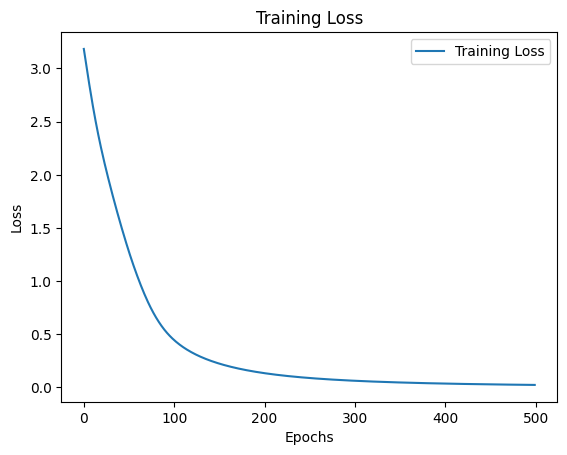

In [6]:
# Plotting training performances
import matplotlib.pyplot as plt
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()

Finally, use the trained model! In this cell:
- Conversion of padded sentences to tensors.
- Usage of the `TinyGPT` model to predict next tokens.
- Reshaping the model output for further processing.
- Extraction of predicted token IDs and conversion back to words.
- Displaying original sentences alongside the model's predictions.

Remember that it's just a toy model, so the generated text won't makes any sense.


In [7]:
# Convert sentences to tensor
tokens_tensor = torch.tensor(padded_sentences).to(device)

# Use the model
model = TinyGPT(vocab_size=vocab_size, d_model=16, num_heads=2).to(device)
output = model(tokens_tensor)
output = output.view(-1, output.size(-1))

# Convert token IDs back to words
_, predicted_token_ids = torch.max(output, dim=1)
predicted_words = [id2word[id.item()] for id in predicted_token_ids]
predicted_sentences = [predicted_words[i:i+max_len] for i in range(0, len(predicted_words), max_len)]

for idx, sentence in enumerate(sentences):
    print(f"Original: {sentence}")
    print(f"Predicted: {' '.join(predicted_sentences[idx])}\n")

Original: Hello world
Predicted: Tiny popular learning BERT transformer

Original: Machine learning is fun
Predicted: transformer cute models cute transformer

Original: Tiny models are cute
Predicted: cute world learning cute transformer

Original: GPT is a transformer model
Predicted: BERT BERT cute learning a

Original: BERT and GPT are popular
Predicted: cute BERT BERT BERT are

